# Generalities for DAEs and VAEs

* Import libraries
* Run on GPU if possible
* Create data loaders

In [7]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt

# create directory to save results
!mkdir results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

mkdir: cannot create directory ‘results’: File exists


# Neural Network classes

* Deterministic auto-encoder (DAE)
* Variational auto-encoder (VAE)


In [63]:
# Deterministic Auto-Encoder (DAE)
class DAE(nn.Module):

    # declare layers
    def __init__(self):
        super(DAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    # encoder: one ReLU hidden layer of 400 nodes, one Linear output layer of 20 nodes
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h)

    # decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    # forward: encoder followed by decoder
    def forward(self, x):
        z = self.encode(x.view(-1, 784))
        return self.decode(z)

# Variational Auto-Encoder (VAE)     
class VAE(nn.Module):

    # declare layers
    def __init__(self):
        super(VAE, self).__init__()

        # dummy assignment until this function is filled in
        # self.fc1 = nn.Linear(1, 1)
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)


    # Encoder: one ReLU hidden layer of 400 nodes, two Linear output layers of 20 nodes (means and log_variances)
    # Input: image (array of size 784)
    # Output: means (array of size 20), log_variances (array of size 20)
    def encode(self, x):

        # dummy assignment until this function is filled in
        # means = torch.randn(x.shape[0], 20).to(device)
        # log_variances = torch.randn(x.shape[0], 20).to(device)
        # return means, log_variances
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    # Reparameterization:
    #
    # Let eps be samples from a Normal(0,1)
    # Input: means (array of size 20), log_variances (array of size 20)
    # Output: embedding (array of size 20 corresponding to means + eps * exponential(log_variances/2))
    def reparameterize(self, means, log_variances):

        # dummy assignment until this function is filled in
        # embedding = torch.randn(means.shape[0], 20).to(device)
        # return embedding
        standard_deviation = torch.exp(0.5*log_variances)
        epsilon = torch.randn_like(standard_deviation)
        return means + epsilon*standard_deviation

    # Decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    # Input: embedding (array of size 20)
    # Output: probability of reconstructed image (array of size 784)
    def decode(self, z):

        # dummy assignment until this function is filled in
        # probabilties = torch.rand(z.shape[0],784).to(device)
        # return probabilties
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    # Function forward: encoder, reparameterize, decoder
    # Input: image
    # Output: probability of reconstructed image, means, log_variances
    def forward(self, x):

        # dummy assignment until this function is filled in
        # probabilties = torch.rand(x.shape[0],20).to(device)
        # means = torch.randn(x.shape[0], 20).to(device)
        # log_variances = torch.randn(x.shape[0], 20).to(device)
        # return probabilties, means, log_variances
        means, log_variances = self.encode(x.view(-1, 784))
        z = self.reparameterize(means, log_variances)
        return self.decode(z), means, log_variances

# Loss Functions

In [64]:
# DAE Loss Function
# Reconstruction loss: binary cross entropy
#
# Inputs:
#    reconstructed_x: reconstructed image
#    x: image
#
# Output:
#    BCE: binary cross entropy  
#
def dae_loss_function(reconstructed_x, x):
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    return BCE

# VAE Loss Function
# Reconstruction loss: binary cross entropy
# KL divergence loss: -0.5 * sum(1 + log_variances - means^2 - exp(log_variances))
#       see Appendix B from VAE paper:
#       Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#       https://arxiv.org/abs/1312.6114
#
# Inputs: 
#    reconstructed_x: reconstructed image
#    x: image
#    means: array of size 20
#    log_variances: array of size 20
#
# Outputs:
#    total_loss: binary cross entropy + KL divergence (scalar)
#    BCE: binary cross entropy (scalar)
#
def vae_loss_function(reconstructed_x, x, means, log_variances):

    # dummy assignment until this function is filled in
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + log_variances - means.pow(2) - log_variances.exp())
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    total_loss = BCE + KLD
    return total_loss, BCE


# Training

In [65]:
# DAE Training
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#    optimizer: DAE optimizer
#
# Outputs:
#    average_train_BCE: binary cross entropy (scalar)
#
def dae_train(epoch, model, optimizer):
    train_BCE = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = dae_loss_function(recon_batch, data)
        loss.backward()
        train_BCE += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('DAE Train Epoch: {} [{}/{} ({:.0f}%)]\ total_Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    average_train_BCE = train_BCE / len(train_loader.dataset)
    print('====> Epoch: {} DAE Average loss: {:.4f}'.format(
          epoch, average_train_BCE))
    return average_train_BCE

# VAE Training
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#    optimizer: VAE optimizer
#
# Outputs:
#    average_train_loss: binary cross entropy + KL divergence (scalar)
#    average_train_BCE: binary cross entropy (scalar)
#
def vae_train(epoch, model, optimizer):

    # dummy assignment until this function is filled in
    # average_train_loss = 0
    # average_train_BCE = 0
    # return average_train_loss, average_train_BCE
    total_loss = 0
    BCE_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, means, log_variances = model(data)
        loss = vae_loss_function(recon_batch, data, means, log_variances)
        loss[0].backward()
        total_loss += loss[0].item()
        BCE_loss += loss[1].item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('VAE Train Epoch: {} [{}/{} ({:.0f}%)]\ total_Loss: {:.6f}\BCE_Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss[0].item() / len(data), loss[1].item() / len(data)))

    average_train_total_loss = total_loss / len(train_loader.dataset)
    average_train_BCE_loss = BCE_loss / len(train_loader.dataset)
    print('====> Epoch: {} VAE Average total loss: {:.4f}'.format(
          epoch, average_train_total_loss))
    print('====> Epoch: {} VAE Average BCE loss: {:.4f}'.format(
          epoch, average_train_BCE_loss))
    return average_train_total_loss, average_train_BCE_loss



# Testing

In [66]:
# DAE Test
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#
# Outputs:
#    average_test_BCE: binary cross entropy (scalar)
#
def dae_test(epoch, model):
    model.eval()
    test_BCE = 10
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_BCE += dae_loss_function(recon_batch, data).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('results/reconstruction_' + str(epoch) + '.png'))

    average_test_BCE = test_BCE / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(average_test_BCE))
    return average_test_BCE

# VAE Test
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#
# Outputs:
#    average_test_loss: binary cross entropy + KL divergence (scalar)
#    average_test_BCE: binary cross entropy (scalar)
#
def vae_test(epoch, model):

    # dummy assignment until this function is filled in
    # average_test_loss = 0
    # average_test_BCE = 0
    # return average_test_loss, average_test_BCE
    model.eval()
    test_total_loss = 0
    test_BCE_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, means, log_variances = model(data)
            test_total_loss += vae_loss_function(recon_batch, data, means, log_variances)[0].item()
            test_BCE_loss += vae_loss_function(recon_batch, data, means, log_variances)[1].item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('results/reconstruction_' + str(epoch) + '.png'))

    average_test_total_loss = test_total_loss / len(test_loader.dataset)
    average_test_BCE_loss = test_BCE_loss / len(test_loader.dataset)
    print('====> Test set total loss: {:.4f}'.format(average_test_total_loss))
    print('====> Test set bce loss: {:.4f}'.format(average_test_BCE_loss))
    return average_test_total_loss, average_test_BCE_loss


# Main

DAE Train Epoch: 1 [0/60000 (0%)]\ total_Loss: 543.492615
DAE Train Epoch: 1 [12800/60000 (21%)]\ total_Loss: 144.181519
DAE Train Epoch: 1 [25600/60000 (43%)]\ total_Loss: 121.297287
DAE Train Epoch: 1 [38400/60000 (64%)]\ total_Loss: 100.771637
DAE Train Epoch: 1 [51200/60000 (85%)]\ total_Loss: 92.576584
====> Epoch: 1 DAE Average loss: 130.7899
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


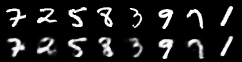

====> Test set loss: 88.5267
Sample of generated images


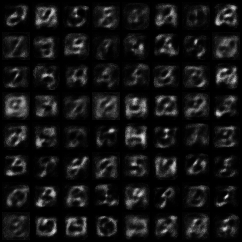



DAE Train Epoch: 2 [0/60000 (0%)]\ total_Loss: 87.716125
DAE Train Epoch: 2 [12800/60000 (21%)]\ total_Loss: 87.640945
DAE Train Epoch: 2 [25600/60000 (43%)]\ total_Loss: 85.833466
DAE Train Epoch: 2 [38400/60000 (64%)]\ total_Loss: 79.806915
DAE Train Epoch: 2 [51200/60000 (85%)]\ total_Loss: 79.517014
====> Epoch: 2 DAE Average loss: 83.4953
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


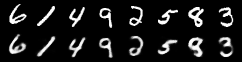

====> Test set loss: 78.4062
Sample of generated images


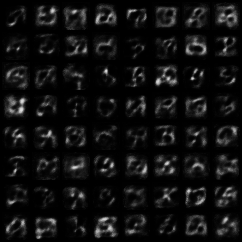



DAE Train Epoch: 3 [0/60000 (0%)]\ total_Loss: 82.314285
DAE Train Epoch: 3 [12800/60000 (21%)]\ total_Loss: 75.336517
DAE Train Epoch: 3 [25600/60000 (43%)]\ total_Loss: 72.801514


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0b8ecc0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0579860>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

DAE Train Epoch: 3 [38400/60000 (64%)]\ total_Loss: 74.740326
DAE Train Epoch: 3 [51200/60000 (85%)]\ total_Loss: 75.468185
====> Epoch: 3 DAE Average loss: 77.3776
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


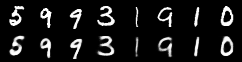

====> Test set loss: 75.0004
Sample of generated images


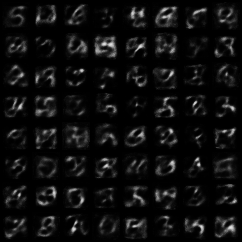



DAE Train Epoch: 4 [0/60000 (0%)]\ total_Loss: 72.524956
DAE Train Epoch: 4 [12800/60000 (21%)]\ total_Loss: 78.618958
DAE Train Epoch: 4 [25600/60000 (43%)]\ total_Loss: 71.468521
DAE Train Epoch: 4 [38400/60000 (64%)]\ total_Loss: 74.252136
DAE Train Epoch: 4 [51200/60000 (85%)]\ total_Loss: 75.611053
====> Epoch: 4 DAE Average loss: 74.5350
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


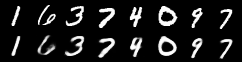

====> Test set loss: 72.7709
Sample of generated images


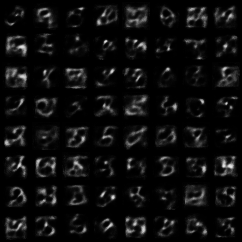



DAE Train Epoch: 5 [0/60000 (0%)]\ total_Loss: 72.594513


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0b8ecc0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0579860>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

DAE Train Epoch: 5 [12800/60000 (21%)]\ total_Loss: 73.922470
DAE Train Epoch: 5 [25600/60000 (43%)]\ total_Loss: 73.332886
DAE Train Epoch: 5 [38400/60000 (64%)]\ total_Loss: 77.120049
DAE Train Epoch: 5 [51200/60000 (85%)]\ total_Loss: 71.042267
====> Epoch: 5 DAE Average loss: 72.7087
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


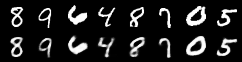

====> Test set loss: 71.6461
Sample of generated images


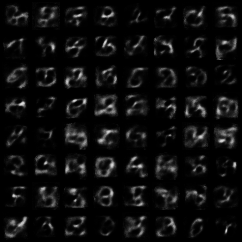



DAE Train Epoch: 6 [0/60000 (0%)]\ total_Loss: 73.311890


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0b8ecc0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0579860>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

DAE Train Epoch: 6 [12800/60000 (21%)]\ total_Loss: 72.697510
DAE Train Epoch: 6 [25600/60000 (43%)]\ total_Loss: 69.878014
DAE Train Epoch: 6 [38400/60000 (64%)]\ total_Loss: 70.064445
DAE Train Epoch: 6 [51200/60000 (85%)]\ total_Loss: 68.231178
====> Epoch: 6 DAE Average loss: 71.4194
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


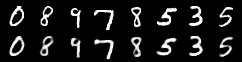

====> Test set loss: 70.5219
Sample of generated images


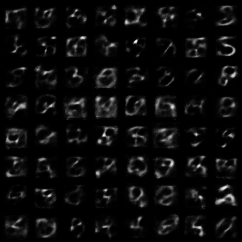



DAE Train Epoch: 7 [0/60000 (0%)]\ total_Loss: 74.103165
DAE Train Epoch: 7 [12800/60000 (21%)]\ total_Loss: 68.910789
DAE Train Epoch: 7 [25600/60000 (43%)]\ total_Loss: 68.294533
DAE Train Epoch: 7 [38400/60000 (64%)]\ total_Loss: 70.805740
DAE Train Epoch: 7 [51200/60000 (85%)]\ total_Loss: 71.162354
====> Epoch: 7 DAE Average loss: 70.4139
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


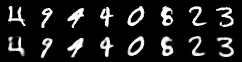

====> Test set loss: 69.7003
Sample of generated images


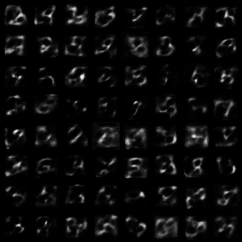



DAE Train Epoch: 8 [0/60000 (0%)]\ total_Loss: 69.215248


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0b8ecc0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0579860>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

DAE Train Epoch: 8 [12800/60000 (21%)]\ total_Loss: 70.797379
DAE Train Epoch: 8 [25600/60000 (43%)]\ total_Loss: 70.713509
DAE Train Epoch: 8 [38400/60000 (64%)]\ total_Loss: 69.298111
DAE Train Epoch: 8 [51200/60000 (85%)]\ total_Loss: 75.309059
====> Epoch: 8 DAE Average loss: 69.6471
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


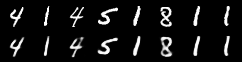

====> Test set loss: 69.0789
Sample of generated images


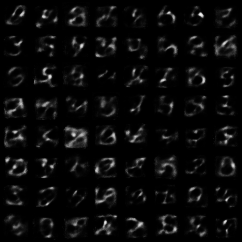



DAE Train Epoch: 9 [0/60000 (0%)]\ total_Loss: 68.363182
DAE Train Epoch: 9 [12800/60000 (21%)]\ total_Loss: 68.133369
DAE Train Epoch: 9 [25600/60000 (43%)]\ total_Loss: 67.123360
DAE Train Epoch: 9 [38400/60000 (64%)]\ total_Loss: 68.907219
DAE Train Epoch: 9 [51200/60000 (85%)]\ total_Loss: 66.891632
====> Epoch: 9 DAE Average loss: 69.0036
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


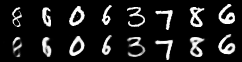

====> Test set loss: 68.5853
Sample of generated images


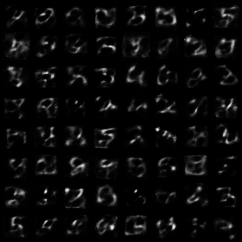

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0b8ecc0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0579860>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

DAE Train Epoch: 10 [0/60000 (0%)]\ total_Loss: 66.547928
DAE Train Epoch: 10 [12800/60000 (21%)]\ total_Loss: 69.686951
DAE Train Epoch: 10 [25600/60000 (43%)]\ total_Loss: 67.162575
DAE Train Epoch: 10 [38400/60000 (64%)]\ total_Loss: 68.241211
DAE Train Epoch: 10 [51200/60000 (85%)]\ total_Loss: 68.852150
====> Epoch: 10 DAE Average loss: 68.4960
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


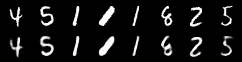

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0b8ecc0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0579860>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

====> Test set loss: 68.2560
Sample of generated images


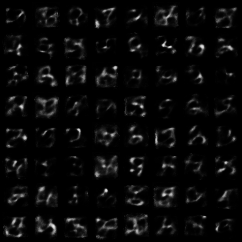



VAE Train Epoch: 1 [0/60000 (0%)]\ total_Loss: 552.176941\BCE_Loss: 552.068176
VAE Train Epoch: 1 [12800/60000 (21%)]\ total_Loss: 184.676697\BCE_Loss: 174.897461
VAE Train Epoch: 1 [25600/60000 (43%)]\ total_Loss: 153.468628\BCE_Loss: 138.314545
VAE Train Epoch: 1 [38400/60000 (64%)]\ total_Loss: 147.062042\BCE_Loss: 128.899521
VAE Train Epoch: 1 [51200/60000 (85%)]\ total_Loss: 130.871887\BCE_Loss: 110.919350
====> Epoch: 1 VAE Average total loss: 165.4647
====> Epoch: 1 VAE Average BCE loss: 150.2515
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


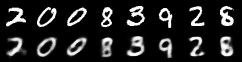

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0b8ecc0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0579860>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

====> Test set total loss: 127.6037
====> Test set bce loss: 106.5055
Sample of generated images


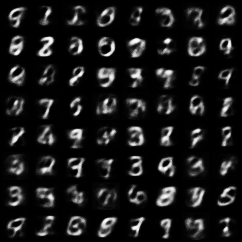



VAE Train Epoch: 2 [0/60000 (0%)]\ total_Loss: 132.833649\BCE_Loss: 111.112831


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0b8ecc0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0579860>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

VAE Train Epoch: 2 [12800/60000 (21%)]\ total_Loss: 123.366127\BCE_Loss: 102.219101
VAE Train Epoch: 2 [25600/60000 (43%)]\ total_Loss: 125.570694\BCE_Loss: 103.201202
VAE Train Epoch: 2 [38400/60000 (64%)]\ total_Loss: 124.061630\BCE_Loss: 101.348312
VAE Train Epoch: 2 [51200/60000 (85%)]\ total_Loss: 120.125244\BCE_Loss: 96.503677
====> Epoch: 2 VAE Average total loss: 121.1630
====> Epoch: 2 VAE Average BCE loss: 98.7500
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


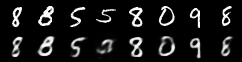

====> Test set total loss: 115.8217
====> Test set bce loss: 91.6195
Sample of generated images


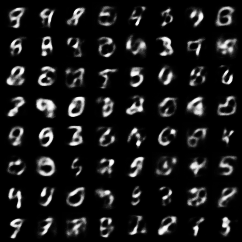



VAE Train Epoch: 3 [0/60000 (0%)]\ total_Loss: 112.291946\BCE_Loss: 87.979797
VAE Train Epoch: 3 [12800/60000 (21%)]\ total_Loss: 118.919281\BCE_Loss: 95.204529
VAE Train Epoch: 3 [25600/60000 (43%)]\ total_Loss: 115.041428\BCE_Loss: 91.682358
VAE Train Epoch: 3 [38400/60000 (64%)]\ total_Loss: 113.639923\BCE_Loss: 89.937286
VAE Train Epoch: 3 [51200/60000 (85%)]\ total_Loss: 117.847382\BCE_Loss: 93.374985
====> Epoch: 3 VAE Average total loss: 114.5609
====> Epoch: 3 VAE Average BCE loss: 90.6931
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


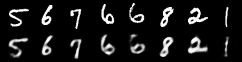

====> Test set total loss: 111.9762
====> Test set bce loss: 87.4699
Sample of generated images


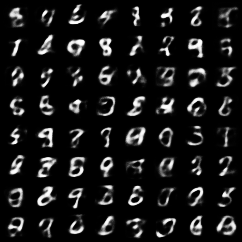



VAE Train Epoch: 4 [0/60000 (0%)]\ total_Loss: 108.185257\BCE_Loss: 84.301506


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0b8ecc0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0579860>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

VAE Train Epoch: 4 [12800/60000 (21%)]\ total_Loss: 114.715073\BCE_Loss: 90.792694
VAE Train Epoch: 4 [25600/60000 (43%)]\ total_Loss: 110.580185\BCE_Loss: 86.275558
VAE Train Epoch: 4 [38400/60000 (64%)]\ total_Loss: 109.195625\BCE_Loss: 84.807289
VAE Train Epoch: 4 [51200/60000 (85%)]\ total_Loss: 112.312393\BCE_Loss: 87.515022
====> Epoch: 4 VAE Average total loss: 111.6510
====> Epoch: 4 VAE Average BCE loss: 87.1030
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


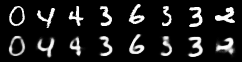

====> Test set total loss: 109.8530
====> Test set bce loss: 85.4674
Sample of generated images


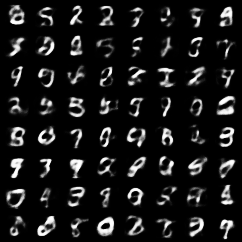



VAE Train Epoch: 5 [0/60000 (0%)]\ total_Loss: 112.219208\BCE_Loss: 87.470001


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0b8ecc0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0579860>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

VAE Train Epoch: 5 [12800/60000 (21%)]\ total_Loss: 112.228394\BCE_Loss: 87.402527
VAE Train Epoch: 5 [25600/60000 (43%)]\ total_Loss: 112.676590\BCE_Loss: 86.479485
VAE Train Epoch: 5 [38400/60000 (64%)]\ total_Loss: 111.701317\BCE_Loss: 86.953835
VAE Train Epoch: 5 [51200/60000 (85%)]\ total_Loss: 108.610901\BCE_Loss: 83.448395
====> Epoch: 5 VAE Average total loss: 109.8368
====> Epoch: 5 VAE Average BCE loss: 85.0255
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


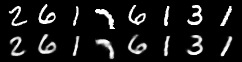

====> Test set total loss: 108.6832
====> Test set bce loss: 84.0434
Sample of generated images


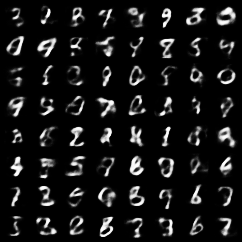



VAE Train Epoch: 6 [0/60000 (0%)]\ total_Loss: 105.932190\BCE_Loss: 81.643585
VAE Train Epoch: 6 [12800/60000 (21%)]\ total_Loss: 107.088593\BCE_Loss: 82.650482
VAE Train Epoch: 6 [25600/60000 (43%)]\ total_Loss: 110.293961\BCE_Loss: 84.455879


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0b8ecc0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0579860>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

VAE Train Epoch: 6 [38400/60000 (64%)]\ total_Loss: 107.136963\BCE_Loss: 81.789917
VAE Train Epoch: 6 [51200/60000 (85%)]\ total_Loss: 104.656693\BCE_Loss: 79.491768
====> Epoch: 6 VAE Average total loss: 108.6623
====> Epoch: 6 VAE Average BCE loss: 83.6666
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


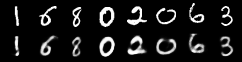

====> Test set total loss: 107.8583
====> Test set bce loss: 82.5703
Sample of generated images


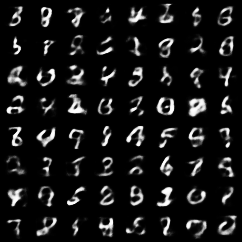

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0b8ecc0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0579860>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

VAE Train Epoch: 7 [0/60000 (0%)]\ total_Loss: 109.388374\BCE_Loss: 83.955048
VAE Train Epoch: 7 [12800/60000 (21%)]\ total_Loss: 107.843102\BCE_Loss: 82.658356
VAE Train Epoch: 7 [25600/60000 (43%)]\ total_Loss: 108.828987\BCE_Loss: 83.840073
VAE Train Epoch: 7 [38400/60000 (64%)]\ total_Loss: 110.590103\BCE_Loss: 85.746902
VAE Train Epoch: 7 [51200/60000 (85%)]\ total_Loss: 102.882202\BCE_Loss: 78.623795
====> Epoch: 7 VAE Average total loss: 107.8205
====> Epoch: 7 VAE Average BCE loss: 82.6732
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


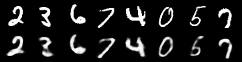

====> Test set total loss: 106.9074
====> Test set bce loss: 81.3959
Sample of generated images


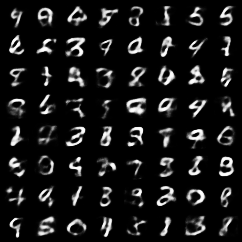



VAE Train Epoch: 8 [0/60000 (0%)]\ total_Loss: 106.325798\BCE_Loss: 80.551407


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0b8ecc0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0579860>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

VAE Train Epoch: 8 [12800/60000 (21%)]\ total_Loss: 101.862625\BCE_Loss: 77.278801
VAE Train Epoch: 8 [25600/60000 (43%)]\ total_Loss: 103.700195\BCE_Loss: 79.091927
VAE Train Epoch: 8 [38400/60000 (64%)]\ total_Loss: 100.696899\BCE_Loss: 76.497284
VAE Train Epoch: 8 [51200/60000 (85%)]\ total_Loss: 108.552216\BCE_Loss: 83.432465
====> Epoch: 8 VAE Average total loss: 107.1404
====> Epoch: 8 VAE Average BCE loss: 81.9289
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


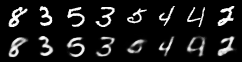

====> Test set total loss: 106.3056
====> Test set bce loss: 81.0156
Sample of generated images


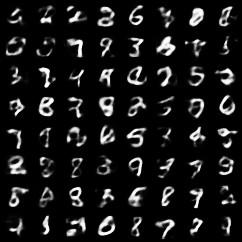



VAE Train Epoch: 9 [0/60000 (0%)]\ total_Loss: 102.479691\BCE_Loss: 78.140282


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0b8ecc0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0579860>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

VAE Train Epoch: 9 [12800/60000 (21%)]\ total_Loss: 108.210800\BCE_Loss: 83.057663
VAE Train Epoch: 9 [25600/60000 (43%)]\ total_Loss: 105.217659\BCE_Loss: 80.149384
VAE Train Epoch: 9 [38400/60000 (64%)]\ total_Loss: 106.171410\BCE_Loss: 81.009262
VAE Train Epoch: 9 [51200/60000 (85%)]\ total_Loss: 107.511063\BCE_Loss: 82.823532
====> Epoch: 9 VAE Average total loss: 106.6630
====> Epoch: 9 VAE Average BCE loss: 81.3531
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


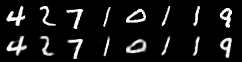

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0b8ecc0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0579860>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

====> Test set total loss: 106.0031
====> Test set bce loss: 80.5741
Sample of generated images


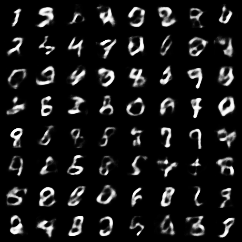



VAE Train Epoch: 10 [0/60000 (0%)]\ total_Loss: 100.395874\BCE_Loss: 76.016113


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0b8ecc0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0579860>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

VAE Train Epoch: 10 [12800/60000 (21%)]\ total_Loss: 105.091690\BCE_Loss: 79.650604
VAE Train Epoch: 10 [25600/60000 (43%)]\ total_Loss: 106.931885\BCE_Loss: 81.252686
VAE Train Epoch: 10 [38400/60000 (64%)]\ total_Loss: 106.756943\BCE_Loss: 81.198296
VAE Train Epoch: 10 [51200/60000 (85%)]\ total_Loss: 106.833687\BCE_Loss: 81.756104
====> Epoch: 10 VAE Average total loss: 106.2222
====> Epoch: 10 VAE Average BCE loss: 80.8794
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


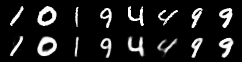

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0b8ecc0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe4a0579860>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

====> Test set total loss: 105.6837
====> Test set bce loss: 80.1087
Sample of generated images


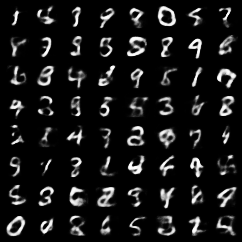

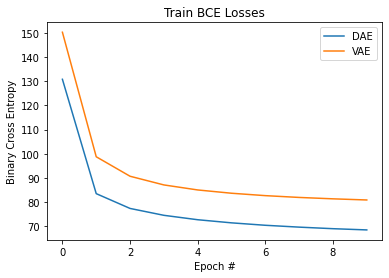

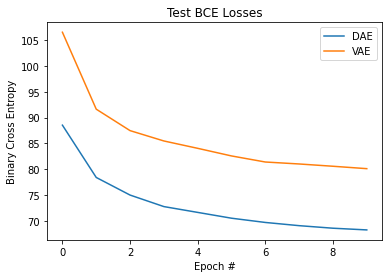

In [67]:
# train and test DAE
epochs = 10
dae_average_train_BCE = []
dae_average_test_BCE = []
dae_model = DAE().to(device)
dae_optimizer = optim.Adam(dae_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    average_train_BCE = dae_train(epoch, dae_model, dae_optimizer)
    dae_average_train_BCE.append(average_train_BCE)
    average_test_BCE = dae_test(epoch, dae_model)
    dae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = dae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# train and test VAE
epochs = 10
vae_average_train_losses = []
vae_average_train_BCE = []
vae_average_test_losses = []
vae_average_test_BCE = []
vae_model = VAE().to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    average_train_loss, average_train_BCE = vae_train(epoch, vae_model, vae_optimizer)
    vae_average_train_losses.append(average_train_loss)
    vae_average_train_BCE.append(average_train_BCE)
    average_test_loss, average_test_BCE = vae_test(epoch, vae_model)
    vae_average_test_losses.append(average_test_loss)
    vae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = vae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train BCE Losses
plt.plot(dae_average_train_BCE)
plt.plot(vae_average_train_BCE)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

# Plot Test BCE Losses
plt.plot(dae_average_test_BCE)
plt.plot(vae_average_test_BCE)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

Comments: Variational Auto-encoder generates better quality images but it also has a higher BCE loss. This makes sense since the goal of DAE is to reconstruct the origianl image, which should be idential as the original image. The goal of VAE is to reconstruct similar images as the original ones with a little variations, in other words, it generates new images according to the conditional distribution for the hidden state. since it samples from underlying distributions in the hidden state. Therefore, it's hard for VAE to reconstruct the original images with very high quality as the DAE, but VAE can generates better novel images with the same features than DAE.